In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
    ]
)



class MyDataset(Dataset):
    def __init__(self,path):
        self.path = path
        self.name = os.listdir(os.path.join(path,'matting/1803151818/matting_00000000'))
        
    def __len__(self):
        return len(self.name)
    
    def __getitem__(self,index):
        segment_name = self.name[index]
        segment_path = os.path.join(self.path,'matting/1803151818/matting_00000000',segment_name)
        image_path = os.path.join(self.path,'clip_img/1803151818/clip_00000000',segment_name.replace('png','jpg'))
        image = Image.open(image_path).resize((256,256))
        segment = Image.open(segment_path).resize((256,256))
        segment = np.array(segment)
        segment[:,:,0][segment[:,:,3]!=0 ] = 255
        segment[:,:,1][segment[:,:,3]!=0 ] = 255
        segment[:,:,2][segment[:,:,3]!=0 ] = 255
        segment = segment[:,:,0:3]
        return transform(image),transform(segment)
    
    

        

/opt/homebrew/Caskroom/miniforge/base/envs/opencv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = MyDataset('archive')

In [4]:
data[0][1].shape

torch.Size([3, 256, 256])

In [5]:
import torch
from torch import nn
from torch.nn import functional as F
class Conv_Block(nn.Module):
    def __init__(self,in_chanel,out_channel):
        super(Conv_Block,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_chanel,out_channel,3,1,1,padding_mode = 'reflect',bias = False),
            nn.BatchNorm2d(out_channel),
            nn.Dropout2d(0.3),
            nn.LeakyReLU(),
            nn.Conv2d(out_channel,out_channel,3,1,1,padding_mode = 'reflect',bias = False),
            nn.BatchNorm2d(out_channel),
            nn.Dropout2d(0.3),
            nn.LeakyReLU(),
        )
    def forward(self,x):
        return self.layer(x)
    
class DownSample(nn.Module):
    def __init__(self,channel):
        super(DownSample,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(channel,channel,3,2,1,padding_mode = 'reflect',bias = False),
            nn.BatchNorm2d(channel),
            nn.LeakyReLU()
        )
    def forward(self,x):
        return self.layer(x)
        
class UpSample(nn.Module):
    def __init__(self,channel):
        super(UpSample,self).__init__()
        self.layer = nn.Conv2d(channel,channel//2,1,1)
    def forward(self,x,feature_map):
        up = F.interpolate(x,scale_factor = 2,mode = 'nearest')
        out = self.layer(up)
        return torch.cat((out,feature_map),dim = 1)
    
    
class UNet(nn.Module):
    def __init__(self):
        super(UNet,self).__init__()
        self.c1 = Conv_Block(3,64)
        self.d1 = DownSample(64)
        self.c2 = Conv_Block(64,128)
        self.d2 = DownSample(128)
        self.c3 = Conv_Block(128,256)
        self.d3 = DownSample(256)
        self.c4 = Conv_Block(256,512)
        self.d4 = DownSample(512)
        self.c5 = Conv_Block(512,1024)
        self.u1 = UpSample(1024)
        self.c6 = Conv_Block(1024,512)
        self.u2 = UpSample(512)
        self.c7 = Conv_Block(512,256)
        self.u3 = UpSample(256)
        self.c8 = Conv_Block(256,128)
        self.u4 = UpSample(128)
        self.c9 = Conv_Block(128,64)
        self.out = nn.Conv2d(64,3,3,1,1)
        self.Th = nn.Sigmoid()
    def forward(self,x):
        R1 = self.c1(x)
        R2 = self.c2(self.d1(R1))
        R3 = self.c3(self.d2(R2))
        R4 = self.c4(self.d3(R3))
        R5 = self.c5(self.d4(R4))
        O1 = self.c6(self.u1(R5,R4))
        O2 = self.c7(self.u2(O1,R3))
        O3 = self.c8(self.u3(O2,R2))
        O4 = self.c9(self.u4(O3,R1))

        return self.Th(self.out(O4))

In [6]:
x = torch.randn(2,3,256,256)
net=UNet()
net(x).shape

torch.Size([2, 3, 256, 256])

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
weight_path = 'params/unet.pth'

save_path = 'train_image'

In [13]:
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torch import optim
data_loader = DataLoader(data,batch_size =8,shuffle = True,num_workers = 0)
net = UNet().to(device)
if os.path.exists(weight_path):
    net.load_state_dict(torch.load(weight_path))
    print('successful load weight')
else:
    print('not successful load weight')
opt = optim.Adam(net.parameters())
loss_fun = nn.BCELoss()

epoch = 1
while True:
    for i,(image,segment_image) in enumerate(data_loader):
        image,segment_image = image.to(device),segment_image.to(device)
        
        out_image = net(image)
        train_loss = loss_fun(out_image,segment_image)
        
        opt.zero_grad()
        train_loss.backward()
        opt.step()
        
        if i%5==0:
            print(f'{epoch}-{i}--train_loss=====>>{train_loss.item()}')
            
        if i%50==0:
            torch.save(net.state_dict(),weight_path)
            
        _image = image[0]
        _segment_image = segment_image[0]
        _out_image = out_image[0]
        img = torch.stack([_image,_segment_image,_out_image],dim=0)
        save_image(img,f'{save_path}/{i}.png')
    epoch+=1

successful load weight
1-0--train_loss=====>>0.11542996019124985
1-5--train_loss=====>>0.12132676690816879


KeyboardInterrupt: 

In [55]:
from torchvision.utils import save_image
unet = UNet()
weight_path = 'params/unet.pth'
if os.path.exists(weight_path):
    unet.load_state_dict(torch.load(weight_path))
    print('successful load weight')
else:
    print('not successful load weight')
    
_input = input('please input image path')
img = Image.open(_input).resize((256,256))

img_data = transform(img)
img_data = torch.unsqueeze(img_data,dim=0)
out = unet(img_data)
save_image(out,'result_image/result.jpg')

successful load weight
please input image patharchive/clip_img/1803191139/clip_00000000/1803191139-00000129.jpg


In [56]:
transform_to_img = transforms.Compose([
    transforms.ToPILImage(), 
    ]
)
seg_img = transform_to_img(out[0])

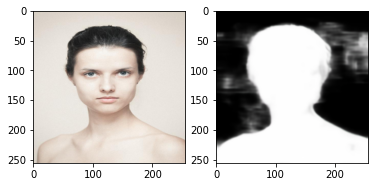

In [57]:
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(seg_img)
